In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import chi2
from scipy.stats import gamma
sns.set(font_scale=2)

# 1. Neyman construction

Вся суть построения Неймана:

1. Некоторым образом оценить распределение оценки параметра по данным от реального значения параметра:

$$p(\hat\theta | \theta)$$

Q1: Какое распределение мы должны уметь считать для построения Неймана?

1) p(\theta | \hat\theta)

2) p(\hat\theta | \theta)

3) p(x | \theta)

4) p(\theta | x)

5) p(\hat\theta | x)

2. Зафиксировать уровень значимости $\alpha$ и ordering rule.

Q2: Что такое ordering rule?

1) Правило выбора (важность) $\theta$ при построении интервала.

2) Функция зависящая от likelihood'а для фиксирования порядка.

3) Скалярная функция f(x) задающая порядок на $\hat\theta$: f(\hat\theta') > f(\hat\theta''), например.

4) Нет правильного ответа.

3. Провести измерение $\hat\theta$.

4. (Предположим что мы считаем двухсторонний интервал) Решить следующие уравнения:

$$\textrm{CDF}( p(\hat\theta | \theta_{low}) ) = \alpha / 2, \textrm{w.r.t. } \theta_{low}$$

$$\textrm{CDF}( p(\hat\theta | \theta_{high}) ) = 1 - \alpha / 2, \textrm{w.r.t. } \theta_{high}$$

5. $[\theta_{low}, \theta_{high}]$ -- наш доверительный интервал.

Делать построение Неймана можно разными способами, в зависимости от того насколько сложное / простое у нас распределение.

## 1.1 Нормальное распределение

### 1. Аналитически

$$p(x | \mu) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}} = N(x|\mu, \sigma)$$

$$\hat\mu = \frac{1}{n} \sum x_i \sim N\left(\hat\mu | \mu, \frac{\sigma^2}{n}\right)$$

$$CDF(p(\hat\mu | \mu )) = \frac{1}{2} \left[ 1 + \mathrm{erf} \left( \frac{\hat\mu - \mu}{\sqrt{2}\sigma} \right) \right]$$

In [2]:
from scipy.stats import norm

In [562]:
mu = 4. # true value
hat_mu = 0.1 # measured value
sigma = 1. # sale
first_type_error_rate = 0.05 # alpha

In [563]:
norm.ppf(first_type_error_rate / 2, loc=hat_mu, scale=sigma), norm.ppf(1 - first_type_error_rate / 2, loc=hat_mu, scale=sigma)

(-1.8599639845400544, 2.059963984540054)

### 2. Численно

In [564]:
from scipy.optimize import minimize, minimize_scalar, brute
from functools import partial

def normal_cdf_opt_problem(x, hat_mu=1., sigma=1, alpha=0.05):
    return (norm.cdf(hat_mu, loc=x, scale=sigma) - alpha)**2

In [565]:
res = minimize(
    partial(normal_cdf_opt_problem, sigma=sigma, alpha=1 - first_type_error_rate / 2, hat_mu=hat_mu), 
    [-2.], method='Nelder-Mead', tol=1e-6)
res.x

array([-1.85996399])

In [566]:
res = minimize(
    partial(normal_cdf_opt_problem, sigma=sigma, alpha=first_type_error_rate / 2, hat_mu=hat_mu), 
    [-2.], method='Nelder-Mead', tol=1e-6)
res.x

array([2.05996399])

## 1.2 Для пуассоновского распределения

Будем для простоты математики рассматривать случай когда у нас выборка состоит из одного измерения, i.e. $X = [x_1]$. Тогда $\hat\lambda = x_1$. 

Q3: Для построения нижнего доверительного интервала нужно минимизировать:
    
1) ((1 - poisson.cdf(k=hat_lam, mu=lam)) - alpha)**2

2) ((1 - poisson.cdf(k=hat_lam + 1, mu=lam)) - alpha)**2

3) ((1 - poisson.cdf(k=hat_lam - 1, mu=lam)) - alpha)**2

4) ((1 - poisson.cdf(k=lam - int(hat_lam), mu=lam)) - alpha)**2


In [12]:
from scipy.stats import poisson
def poisson_cdf_opt_problem(lam, hat_lam=1., upper=True, alpha=0.05):
    if upper:
        return (poisson.cdf(k=hat_lam, mu=lam) - alpha)**2
    else:
        return (
            (1 - poisson.cdf(k=hat_lam - 1, mu=lam)) - alpha
        )**2

In [27]:
upper_bounds = []
upper_bounds_one_sided = []
lower_bounds = []

hat_lams = np.arange(200) 
for hat_lam in hat_lams:
    res = minimize(partial(poisson_cdf_opt_problem, alpha=first_type_error_rate / 2, upper=True, hat_lam=hat_lam), [hat_lam], method='Nelder-Mead', tol=1e-6)
    upper_bounds.append(res.x[0])
    res = minimize(partial(poisson_cdf_opt_problem, alpha=first_type_error_rate / 2, upper=False, hat_lam=hat_lam), [hat_lam / 2], method='Nelder-Mead', tol=1e-6)
    lower_bounds.append(res.x[0])
    
    res = minimize(partial(poisson_cdf_opt_problem, alpha=first_type_error_rate, upper=True, hat_lam=hat_lam), [hat_lam], method='Nelder-Mead', tol=1e-6)
    upper_bounds_one_sided.append(res.x[0])

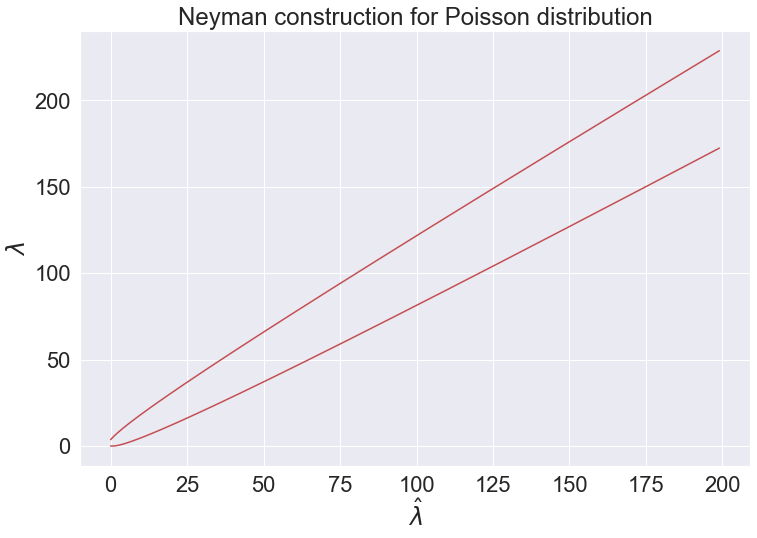

In [28]:
plt.figure(figsize=(12, 8))
# plt.plot(hat_lams, upper_bounds_one_sided, c="b")
plt.plot(hat_lams, upper_bounds, c="r")
plt.plot(hat_lams, lower_bounds, c="r")
plt.xlabel(r"$\hat\lambda$")
plt.ylabel(r"$\lambda$")
plt.title("Neyman construction for Poisson distribution")
plt.show()

In [29]:
def calculate_coverage_for_poisson(lam, lower_bounds, upper_bounds):
    coverage = 0
    for i in range(len(lower_bounds)):
        if lower_bounds[i] <= lam <= upper_bounds[i]:
            coverage += poisson.pmf(k=i, mu=lam)
    return coverage

100%|██████████| 100/100 [00:03<00:00, 26.46it/s]


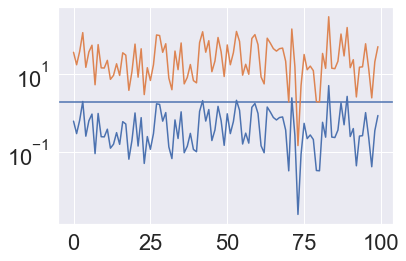

In [227]:
left, right

(5.652349871796789, 5.652349871796789)

In [214]:
res

      fun: array([2.6981326e-14])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.41849949e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 3
     njev: 12
   status: 0
  success: True
        x: array([0.90356129])

In [30]:
coverage = []
for lam in np.linspace(1, 100, 100):    
    coverage.append(
        calculate_coverage_for_poisson(lam=lam, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
    )

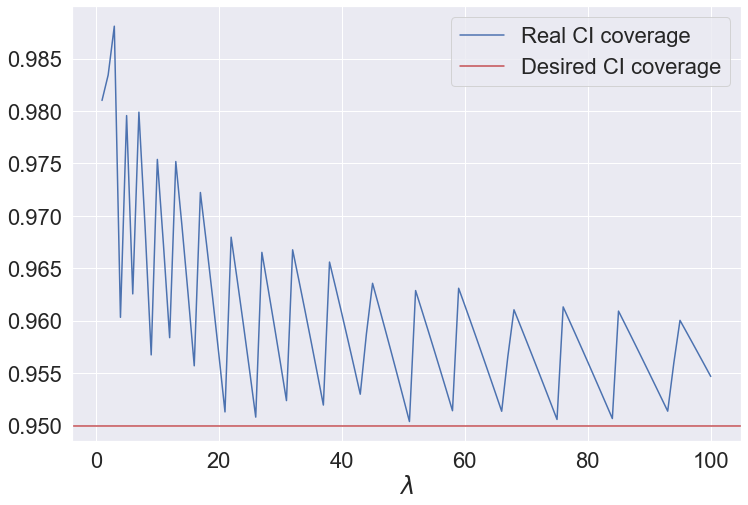

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(1, 100, 100), coverage, label="Real CI coverage")
plt.axhline(1 - first_type_error_rate, c='r', label="Desired CI coverage")
plt.xlabel(r"$\lambda$")
plt.legend()
plt.show()

Q4: Cлучайно ли что тест даёт overcoverage?
    
1) Да, случайно повезло с Пуассоновским распределением.

2) Нет, не случайно.

Q5: Что такое p-value?

1) Вероятность того что наша гипотеза о данных верна.

2) Вероятность пронаблюдать более экстремальное значение чем то что намеряли.

3) Вероятность пронаблюдать намерянные данные при предположении что наша гипотеза верна.

4) Вероятность того что наша гипотеза о данных не верена.

5) Нет верного ответа

In [457]:
res = minimize(
        partial(expon_cdf_opt_problem, alpha=first_type_error_rate / 2, n=n, hat_lam=hat_lam), 
        [hat_lam / 2], tol=1e-3)
res

      fun: 0.0024953523545692543
 hess_inv: array([[1]])
      jac: array([4.81822644e-06])
  message: 'Optimization terminated successfully.'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([7.91873478])

### Плотность "уверенности"

1. Фиксируем (измерением) $\hat\lambda$

2. Считаем производную от P-value($\hat\lambda$) по параметру $\lambda$

$$c(\lambda) = \frac{d}{d \lambda} P(T \geq \hat\lambda | \lambda)$$

3. Данная величина в статистике называется плотностью уверенности. Она показывает нашу субъективную уверенность где находится $\lambda$.

#### В реальности есть небольшой произвол как посчитать P-value (в зависимости хотим мы односторонний или двухсторонний интервал):

Для построения Неймана мы решали два этих уравнения:

$$p(T \geq \hat\lambda | \lambda) = \alpha / 2$$

$$p(T > \hat\lambda | \lambda) = 1 - \alpha / 2$$

Поэтому p-value жутко неочевидно как посчитать. Возможные варианты:

$$\mathrm{p-value}(\hat\theta) = P(T \geq \hat\theta | \lambda)$$

$$\mathrm{p-value}(\hat\theta) = P(T > \hat\theta | \lambda)$$

$$\mathrm{p-value}(\hat\theta) = P(T > \hat\theta | \lambda) + \frac{1}{2} P(T = \hat\theta | \lambda)$$

Доп литература: Lancaster (1961), Agresti (1996).

In [32]:
from scipy.misc import derivative
hat_lam = 3

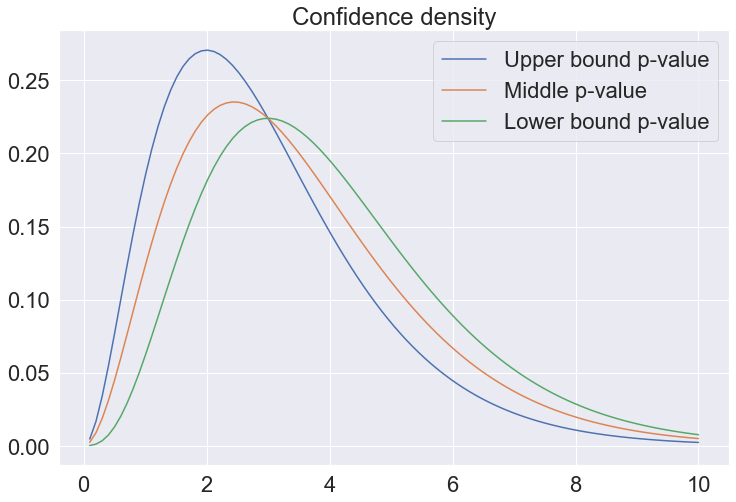

In [33]:
lam = np.linspace(0, 10, 100)

plt.figure(figsize=(12, 8))
poisson_p_value = lambda lam, hat_lam: 1 - poisson.cdf(mu=lam, k=hat_lam) + poisson.pmf(mu=lam, k=hat_lam)
plt.plot(
    lam,
    derivative(partial(poisson_p_value, hat_lam=hat_lam), x0=lam, dx=0.001),
    label="Upper bound p-value"
)

poisson_p_value = lambda lam, hat_lam: 1 - poisson.cdf(mu=lam, k=hat_lam) + poisson.pmf(mu=lam, k=hat_lam) / 2
plt.plot(
    lam,
    derivative(partial(poisson_p_value, hat_lam=hat_lam), x0=lam, dx=0.001),
    label="Middle p-value"
)

poisson_p_value = lambda lam, hat_lam: (1 - poisson.cdf(mu=lam, k=hat_lam)) 
plt.plot(
    lam,
    derivative(partial(poisson_p_value, hat_lam=hat_lam), x0=lam, dx=0.001),
    label="Lower bound p-value"
)
plt.title("Confidence density")
plt.legend()
plt.show()

## 1.3 Для бернулли

In [34]:
from scipy.stats import binom
from scipy.optimize import brute

def bernoulli_cdf_opt_problem(p, x, n, upper=True, alpha=0.05):
    if upper:
        return (
            binom.cdf(x, n=n, p=p) - alpha
        )**2
    else:
        return (
            (1 - binom.cdf(x - 1, n=n, p=p)) - alpha
        )**2

In [35]:
EPS = 1e-3

In [41]:
n = 100
upper_bounds = []
lower_bounds = []
seeds = np.linspace(EPS, 1 - EPS, 10000)
for x in np.arange(0, n + 1):
    x_init = np.argmin((binom.cdf(x - 1, n=n, p=seeds) - first_type_error_rate / 2)**2)
    x_init = seeds[x_init]
    res = minimize(
        partial(bernoulli_cdf_opt_problem, alpha=first_type_error_rate / 2, upper=True, n=n, x=x), 
        [x_init], 
        method='Nelder-Mead', tol=1e-6, options={"maxiter": 1e5})
    upper_bounds.append(res.x[0])
    
    x_init = np.argmin((1 - binom.cdf(x - 1, n=n, p=seeds) - first_type_error_rate / 2)**2)
    x_init = seeds[x_init]
    res = minimize(
        partial(bernoulli_cdf_opt_problem, alpha=first_type_error_rate / 2, upper=False, n=n, x=x), 
        [x_init], 
        method='Nelder-Mead', tol=1e-6, options={"maxiter": 1e5})
    lower_bounds.append(res.x[0])

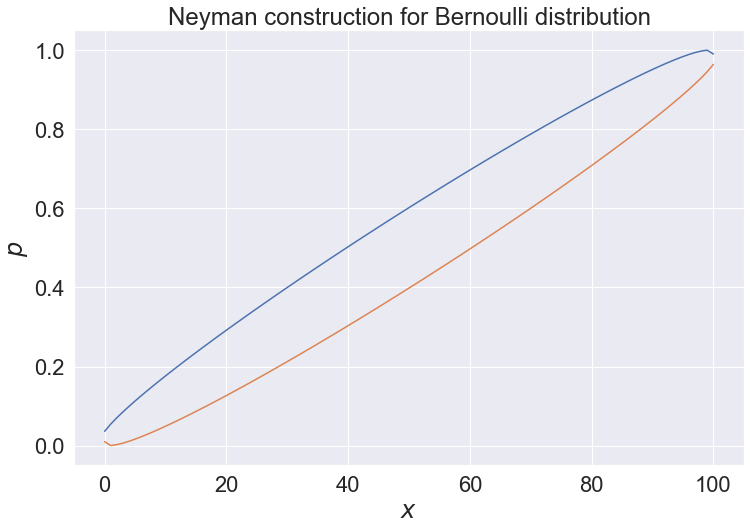

In [42]:
plt.figure(figsize=(12, 8))

plt.plot(np.arange(0, n + 1), upper_bounds)
plt.plot(np.arange(0, n + 1), lower_bounds)
plt.xlabel(r"$x$")
plt.ylabel(r"$p$")
plt.title("Neyman construction for Bernoulli distribution")
plt.show()

In [43]:
def calculate_coverage_for_bernoulli(p, n, lower_bounds, upper_bounds):
    coverage = 0
    for i in range(len(lower_bounds)):
        if lower_bounds[i] <= p <= upper_bounds[i]:
            coverage += binom.pmf(i, p=p, n=n)
    return coverage

In [44]:
coverage = []
EPS = 1e-2
for p in np.linspace(EPS, 1 - EPS, 100):    
    coverage.append(
        calculate_coverage_for_bernoulli(p=p, n=n, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
    )

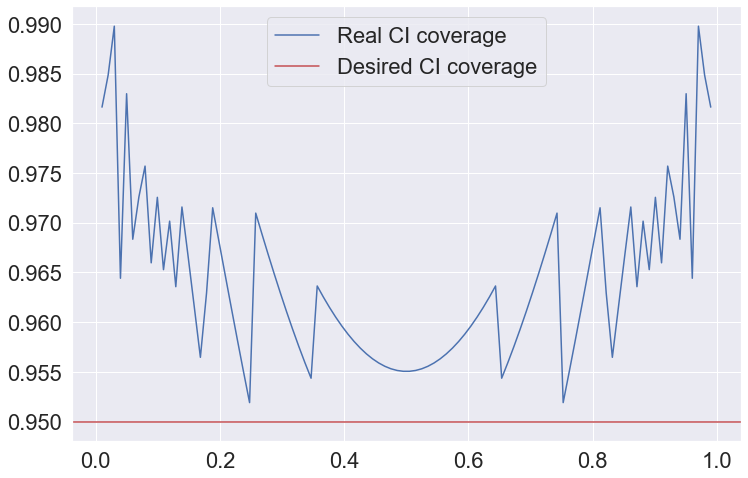

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(EPS, 1 - EPS, 100), coverage, label="Real CI coverage")
plt.axhline(1 - first_type_error_rate, c='r', label="Desired CI coverage")
plt.legend()
plt.show()

### Плотность "уверенности"

In [92]:
p = 0.5
n = 100

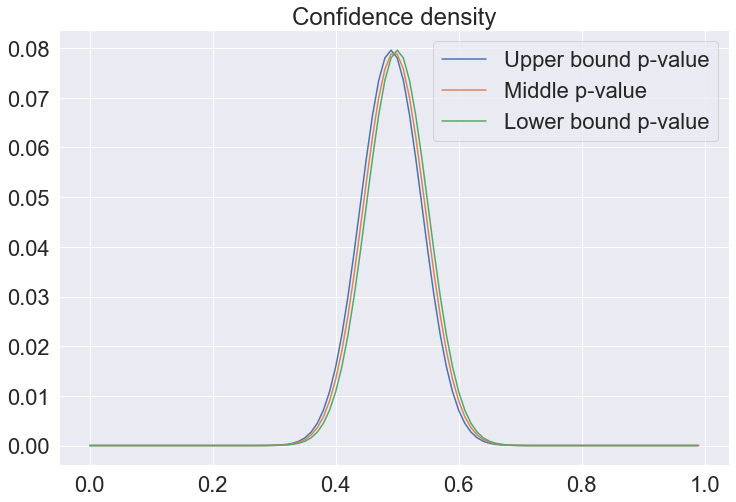

In [93]:
x = np.arange(0, n + 1)

plt.figure(figsize=(12, 8))

bernoulli_p_value = lambda p, x, n: -(1 - binom.cdf(x, n=n, p=p))
plt.plot(
    x[:-1] / n,
    np.diff(bernoulli_p_value(p=p, x=x, n=n)),
    label="Upper bound p-value"
)

bernoulli_p_value = lambda p, x, n: -((1 - binom.cdf(x, n=n, p=p)) + binom.pmf(x, n=n, p=p) / 2)
plt.plot(
    x[:-1] / n,
    np.diff(bernoulli_p_value(p=p, x=x, n=n)),
    label="Middle p-value"
)

bernoulli_p_value = lambda p, x, n: -((1 - binom.cdf(x, n=n, p=p)) + binom.pmf(x, n=n, p=p))
plt.plot(
    x[:-1] / n,
    np.diff(bernoulli_p_value(p=p, x=x, n=n)),
    label="Lower bound p-value"
)

plt.title("Confidence density")
plt.legend()
plt.show()

In [ ]:
bernoulli_p_value = lambda p, x, n: -((1 - binom.cdf(x, n=n, p=p)) + binom.pmf(x, n=n, p=p) / 2)
plt.plot(
    x[:-1] / n,
    np.diff(bernoulli_p_value(p=p, x=x, n=n)),
    label="Middle p-value"
)

## Для гамма-распределения (чуть больше грустных симуляций)

In [54]:
gamma?

In [49]:
from collections import defaultdict
from scipy.stats import gamma

In [50]:
# true parameters of the distribution
alpha = 0.23
beta = 5.35

In [51]:
# simulations fo the dataset
boot_size = 1000
betas = np.linspace(3, 8, 50)
distributions_of_beta_hat = defaultdict(list)
for beta in betas:
    for _ in range(boot_size):
        X = gamma.rvs(scale=1 / beta, a=alpha, size=1000)
        _, _, fit_beta = gamma.fit(X, floc=0, fa=alpha)
        distributions_of_beta_hat[beta].append(1 / fit_beta)

In [52]:
# test statistic estimated from data
first_type_error_rate = 0.1
beta_hat_from_data = 6.0

upper_bound = None
for beta in betas:
    if np.mean(np.array(distributions_of_beta_hat[beta]) < beta_hat_from_data) < first_type_error_rate / 2:
        upper_bound = beta
        break
        
lower_bound = None
for beta in betas[::-1]:
    if np.mean(np.array(distributions_of_beta_hat[beta]) > beta_hat_from_data) < first_type_error_rate / 2:
        lower_bound = beta
        break

In [53]:
lower_bound, upper_bound

(5.244897959183674, 6.775510204081632)

### Построим доверительный пояс

In [55]:
upper_bounds = []
lower_bounds = []
beta_hats = np.linspace(4.5, 6, 20)
for beta_hat in beta_hats:
    upper_bound = None
    for beta in betas:
        if np.mean(np.array(distributions_of_beta_hat[beta]) < beta_hat) < first_type_error_rate / 2:
            upper_bound = beta
            break

    lower_bound = None
    for beta in betas[::-1]:
        if np.mean(np.array(distributions_of_beta_hat[beta]) > beta_hat) < first_type_error_rate / 2:
            lower_bound = beta
            break
    upper_bounds.append(upper_bound)
    lower_bounds.append(lower_bound)

In [56]:
plt.figure(figsize=(12, 8))
plt.title("Neyman construction for Gamma distribution")
plt.fill_between(beta_hats, lower_bounds, upper_bounds, alpha=0.5)
plt.xlabel(r"$\hat\beta$")
plt.ylabel(r"$\beta$")
plt.show()

# Feldman-Cousine intervals

## Flip-flop problem

Q6: Какая задача ставится в flip-flop problem?

1) Проблема построения доверительных интервалов для дискретных распределений (flip-flop называется из-за ассоциации с распределением бросков монетки)

2) Мы хотим дать односторонний доверительный интервал если высока вероятность верности гипотезы (\mu > 3 \sigma) и двусторонний если вероятность верности гипотезы мала.

3) Мы хотим дать двусторонний доверительный интервал если высока вероятность верности гипотезы (\mu > 3 \sigma) и односторонний если вероятность верности гипотезы мала.

In [195]:
sigma = 1.
upper_bounds = []
lower_bounds = []
alpha = 0.1
hat_mus = np.linspace(-1, 8, 1000)
for hat_mu in hat_mus:
    if hat_mu < sigma * 3:
        lower_bounds.append(0)
        upper_bounds.append(norm.ppf(1 - alpha, loc=hat_mu, scale=sigma))
    else:
        lower_bounds.append(norm.ppf(alpha / 2, loc=hat_mu, scale=sigma))
        upper_bounds.append(norm.ppf(1 - alpha / 2, loc=hat_mu, scale=sigma))

No handles with labels found to put in legend.


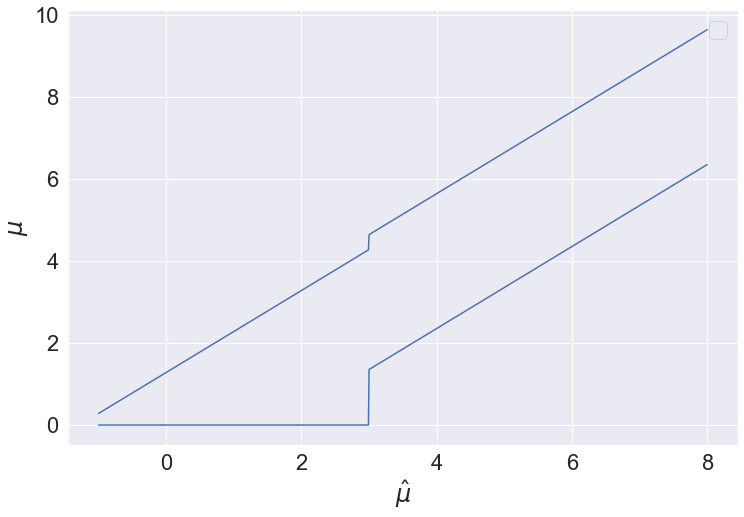

In [196]:
plt.figure(figsize=(12, 8))

plt.plot(hat_mus, upper_bounds, c="b")
plt.plot(hat_mus, lower_bounds, c="b")

plt.xlabel(r"$\hat\mu$")
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

Q7: Почему это плохой интервал?

1) Он даёт недопокрытие в левой части графика.

2) Он даёт перепокрытие в левой части графика.

3) Он даёт недопокрытие в правой части графика.

4) Он даёт перепокрытие в правой части графика.

5) Он даёт недопокрытие в средней части графика.

6) Он даёт перепокрытие в средней части графика.

No handles with labels found to put in legend.


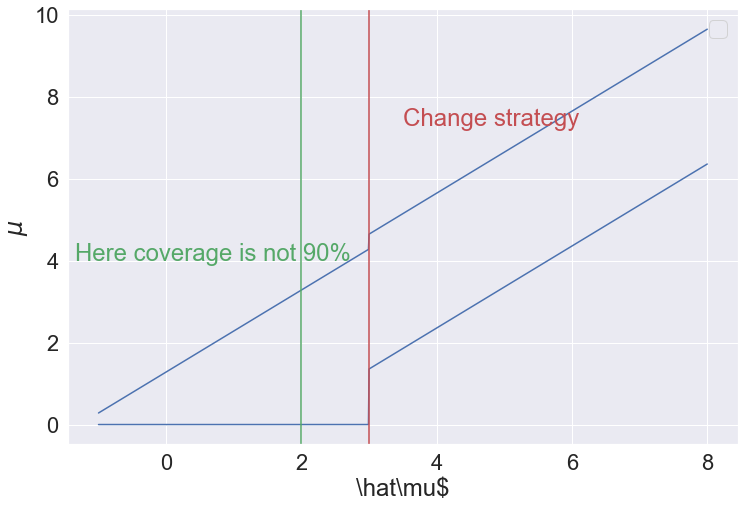

In [210]:
plt.figure(figsize=(12, 8))

plt.plot(hat_mus, upper_bounds, c="b")
plt.plot(hat_mus, lower_bounds, c="b")

plt.axvline(3, c="r")
plt.axvline(2, c="g")
plt.text(-1.35, 4, "Here coverage is not 90%", c='g')
plt.text(3.5, 7.3, "Change strategy", c="r")
plt.xlabel(r"\hat\mu$")
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

### Что же делать?

## Feldman-Cousine technique

Делать построение Неймана следующим образом:

$$\hat\Theta: \begin{cases}
    \frac{p(\hat\theta | \theta)}{p(\hat\theta | \theta_{max})} \geq \kappa \\
    \kappa: P(\hat\Theta) = 1 - \alpha
\end{cases},
$$

где $\theta_{max}$ выбирается по MLE в __области допустимых значений__.

### Предложенный алгоритм

In [185]:
mu = 0.1
sigma = 1.

In [186]:
def simulate_likelihood_ratios(mu, sigma, boot=20000):
    likelihood_ratios = []
    hat_mus = []
    hat_mus = norm.rvs(size=boot, loc=mu, scale=sigma)
    likelihood_ratios = (
        norm.logpdf(hat_mus, loc=np.clip(hat_mus, 0, np.inf), scale=sigma) - 
        norm.logpdf(hat_mus, loc=mu, scale=sigma)
    )
    idx_sorted = np.argsort(hat_mus)
    hat_mus = np.array(hat_mus)[idx_sorted]
    likelihood_ratios = np.array(likelihood_ratios)[idx_sorted]
    return hat_mus, likelihood_ratios

In [187]:
first_type_error_rate = 0.1

In [188]:
hat_mus, likelihood_ratios = simulate_likelihood_ratios(mu, sigma)
cut_value = np.percentile(likelihood_ratios, q=100 * (1 - first_type_error_rate))

In [189]:
hat_mus[likelihood_ratios < cut_value].min(), hat_mus[likelihood_ratios < cut_value].max()

(-3.7975675032203444, 1.382009969280143)

In [190]:
plt.figure(figsize=(12, 8))

plt.hist(hat_mus, bins=50, density=True);
plt.ylabel("Density")

plt.twinx()
window = 10
plt.plot(
    pd.Series(hat_mus).rolling(window=window).mean(),
    pd.Series(likelihood_ratios).rolling(window=window).mean(),
    c='y',
    label="Likelihood ratio"
)
plt.axhline(cut_value, label="Cut value")
plt.xlabel(r"$\hat\mu$")
plt.ylabel("Likelihood ratio")
plt.legend()

plt.show()

In [191]:
mus = np.linspace(0.1, 5, 50)
upper_bounds = []
lower_bounds = []
for mu in tqdm(mus):
    hat_mus, likelihood_ratios = simulate_likelihood_ratios(mu, sigma, boot=40000)
    cut_value = np.percentile(likelihood_ratios, q=100 * (1 - first_type_error_rate))
    lower_bounds.append(hat_mus[likelihood_ratios < cut_value].min())
    upper_bounds.append(hat_mus[likelihood_ratios < cut_value].max())

100%|██████████| 50/50 [00:01<00:00, 42.98it/s]


In [193]:
plt.figure(figsize=(12, 8))
plt.plot(lower_bounds, mus, c="b")
plt.plot(upper_bounds, mus, c="b")
plt.xlabel(r"$\hat\mu$")
plt.ylabel(r"$\mu$")

plt.axhline(3, c="r")
plt.axvline(3, c="g")
plt.text(3.1, 1, "Here coverage is OK now!")
plt.text(7, 3.3, "Change strategy", c="r")
plt.xlabel(r"$\hat\mu$")
plt.ylabel(r"$\mu$")

plt.show()

# 3. MAP with Jeffrey's prior

Предположим, что вы подбросили моменту один раз и у вас выпал орёл. 

Распределение описывается распредлением Бернулли: $p(x=1, q) = q$.

Для выборки $x_1, x_2, \dots, x_N$ правдоподобие записывается следующим образом:

$$p(X, q) = \prod q^{x_i} (1 - q)^{1-x_i}$$

$$\log p(X, q) = \sum\left[ x_i \log q + (1 - x_i) \log(1 - q) \right]$$

Тогда оценка на параметры высчитывается следующим образом:


$$\frac{\partial }{\partial q} \log p(X, q) = \frac{1}{q} \sum x_i - \frac{1}{1-q} \sum (1 - x_i) = 0$$

Получаем:

$$q = \frac{\sum x_i}{n}$$

В согласии с методом максимума правдоподобия следует, что $p=1$, т.е. следует что монетка всегда будет выпадать орлом.

Такая оценка не очень хорошо согласуется с реальностью. 

### В этот раз вы не знаете какое распределение ожидать, но всё равно хотите какой-нибудь прайор забабахать и быть байесианцами

В таком случае самый оптимальный вариант -- неинформативный прайор Джеффри:

$$p(q) \sim \sqrt{I(q)}, I(q) = \frac{1}{q(1 - q)}$$

$$p(q) \sim \frac{1}{\sqrt{q (1 - q)}}$$


Лог-вероятность:

$$\log p(X, q) p(q) = -\frac{1}{2}\log q -\frac{1}{2} \log (1 - q) +  \sum\left[ x_i \log q + (1 - x_i) \log( - q) \right] $$

Производная:


$$\frac{\partial }{\partial q} \log p(X, q) p(q) = $$

$$ = \frac{1}{q} \sum x_i - \frac{1}{1-q} \sum (1 - x_i) - \frac{1}{2q} + \frac{1}{2(1 - q)} = 0$$


$$q = \frac{\sum x_i + 1 / 2}{n + 1}$$

In [ ]:
def bernoulli_jeffreys_prior(q):
    return 1 / np.sqrt(q * (1 - q))

In [ ]:
from scipy.stats import beta
a = b = 1.
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 1000)

plt.figure(figsize=(12, 8))
plt.plot(
    x, beta.pdf(x, a, b),
    'r-', lw=5, alpha=0.6, label='Beta({}, {})'.format(a, b)
)
plt.plot(
    x, bernoulli_jeffreys_prior(x),
    'g', lw=5, alpha=0.6, label="Jeffrey's prior"
)

plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
theta = 0.01
coin_flips = np.random.binomial(n=1, p=theta, size=100)

plt.figure(figsize=(10, 8), dpi=100)

a = b = 1.
plt.plot((np.cumsum(coin_flips) + a - 1) / (np.cumsum(np.ones_like(coin_flips)) + b + a - 2), label="a={}, b={}".format(a, b))

plt.plot((np.cumsum(coin_flips) + 1 / 2) / (np.cumsum(np.ones_like(coin_flips)) + 1), label="Jeffreys prior")

plt.plot(np.cumsum(coin_flips) / np.cumsum(np.ones_like(coin_flips)), label="MLE")

plt.legend()

## Q8: В чём же неинформативность прайора Джеффри?

1) В одномерном случае KL расстояние между прайором и постериором максимальна. 

2) Если какие-то параметры поменяют единицы измерения (кг -> граммы, метры в сантиметры), то ответ не поменяется.

3) "Выравнивает" важность между различными измерениями. 

4) Постериор инвариантен для разных параметризаций (с точностью до замены переменных).

In [85]:
x = np.random.random(size=10)
y = np.random.random(size=10) + 0.1
z = np.random.random(size=10) - 0.1

In [86]:
q = np.concatenate([x, y, z])

In [87]:
np.percentile(q, 25), np.percentile(q, 75)

(0.17890129919460626, 0.621011686691521)

In [88]:
x.mean(), y.mean(), z.mean()

(0.28666831749978294, 0.592261885020789, 0.46589710668867435)

In [89]:
np.percentile([x.mean(), y.mean(), z.mean()], 25), np.percentile([x.mean(), y.mean(), z.mean()], 75)

(0.37628271209422864, 0.5290794958547317)

In [91]:
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'sklearn'